## AIR QUALITY HEALTH DATA: CLEANING, PREPROCESSING & EDA


In [71]:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")



## 1. DATA LOADING AND INITIAL EXPLORATION




In [72]:
# Load the dataset
data = pd.read_csv('air_quality_health_dataset.csv')
print("=== DATASET OVERVIEW ===")
print(f"Shape: {data.shape}")
print(f"Columns: {list(data.columns)}")
print("=== FIRST 5 ROWS ===")
print(data.head())
print("=== DATA TYPES ===")
print(data.dtypes)
print("=== BASIC STATISTICS ===")
print(data.describe())

=== DATASET OVERVIEW ===
Shape: (3000, 26)
Columns: ['date', 'region', 'AQI', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'temperature', 'humidity', 'wind_speed', 'precipitation', 'hospital_visits', 'emergency_visits', 'mobility_index', 'school_closures', 'public_transport_usage', 'mask_usage_rate', 'lockdown_status', 'industrial_activity', 'vehicle_count', 'construction_activity', 'respiratory_admissions', 'population_density', 'green_cover_percentage']
=== FIRST 5 ROWS ===
         date   region         AQI      PM2.5       PM10        NO2  \
0  2020-01-01     East  109.934283  31.382887  57.718373  47.654022   
1  2020-01-02  Central   97.234714  47.094225  67.381383  50.734127   
2  2020-01-03     East  112.953771  53.795917  61.158796  44.986899   
3  2020-01-04     West  130.460597  88.315315  69.040084  20.575023   
4  2020-01-05    South   95.316933  68.348297  75.716994  38.445776   

         SO2        CO         O3  temperature  ...  school_closures  \
0  25.874070  0.956973

## 2. DATA CLEANING & MISSING VALUES

In [73]:

print("\n=== MISSING VALUES CHECK ===")
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])
print(f"Total missing values: {data.isnull().sum().sum()}")

# Check for duplicates
print(f"\nDuplicate rows: {data.duplicated().sum()}")

# Convert date column to datetime
data['date'] = pd.to_datetime(data['date'])

# Extract date features
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek
data['quarter'] = data['date'].dt.quarter

print("✓ Date conversion and feature extraction completed")


=== MISSING VALUES CHECK ===
Series([], dtype: int64)
Total missing values: 0

Duplicate rows: 0
✓ Date conversion and feature extraction completed


## 3. OUTLIER DETECTION AND HANDLING



=== OUTLIER DETECTION ===
AQI: 29 outliers (0.97%)
PM2.5: 26 outliers (0.87%)
PM10: 19 outliers (0.63%)
NO2: 28 outliers (0.93%)
SO2: 23 outliers (0.77%)
CO: 19 outliers (0.63%)
O3: 23 outliers (0.77%)
temperature: 13 outliers (0.43%)
hospital_visits: 13 outliers (0.43%)
emergency_visits: 50 outliers (1.67%)
mobility_index: 21 outliers (0.70%)
school_closures: 278 outliers (9.27%)
lockdown_status: 431 outliers (14.37%)
respiratory_admissions: 23 outliers (0.77%)


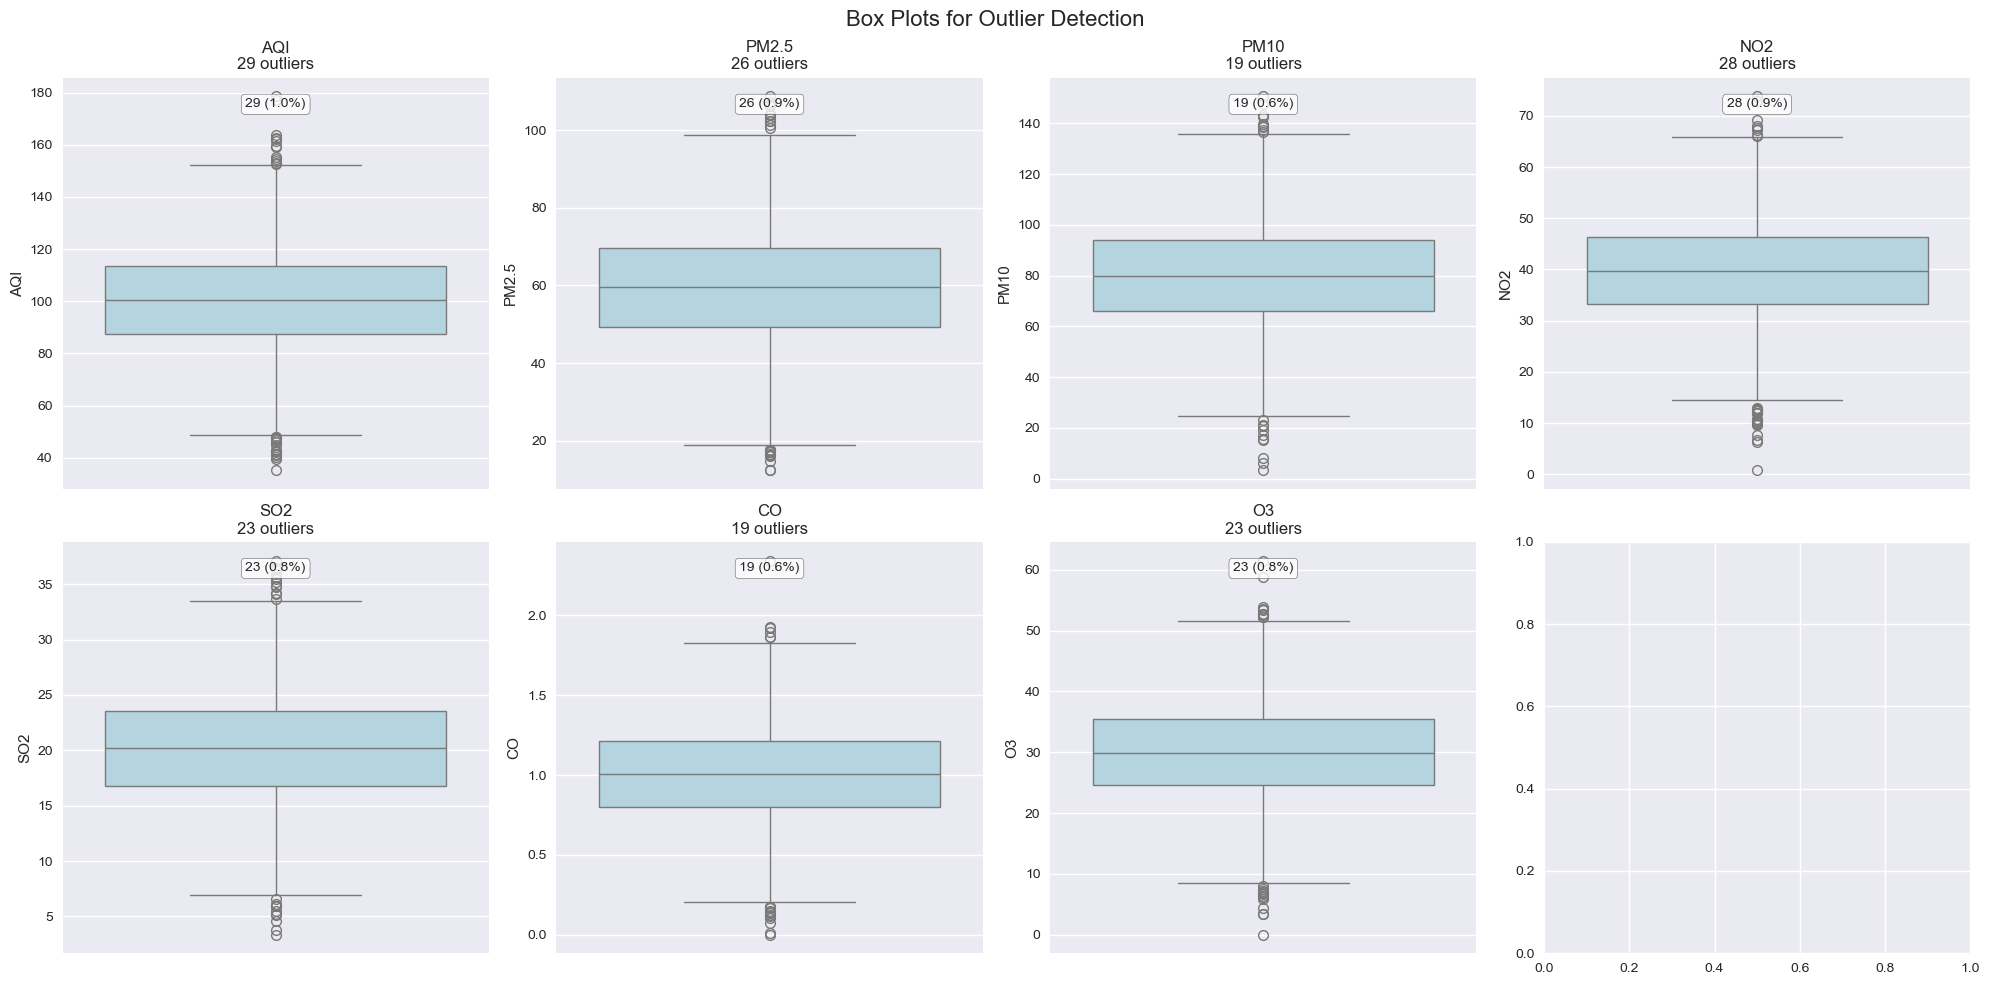

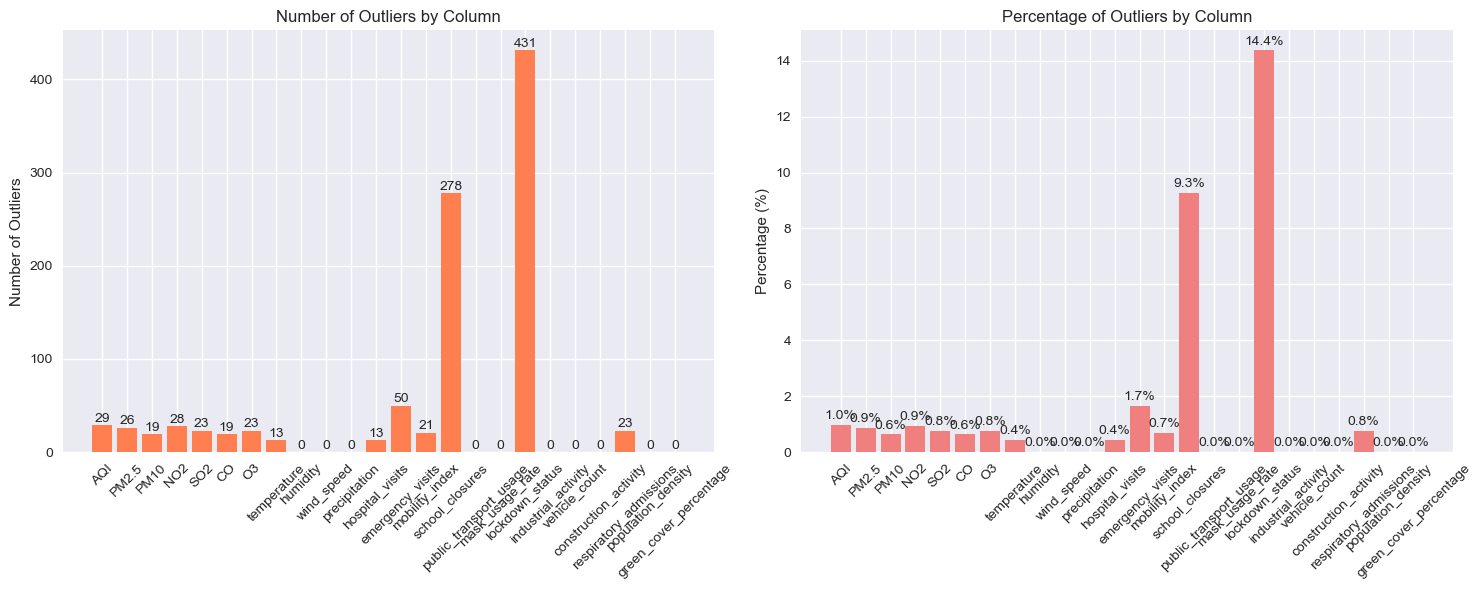

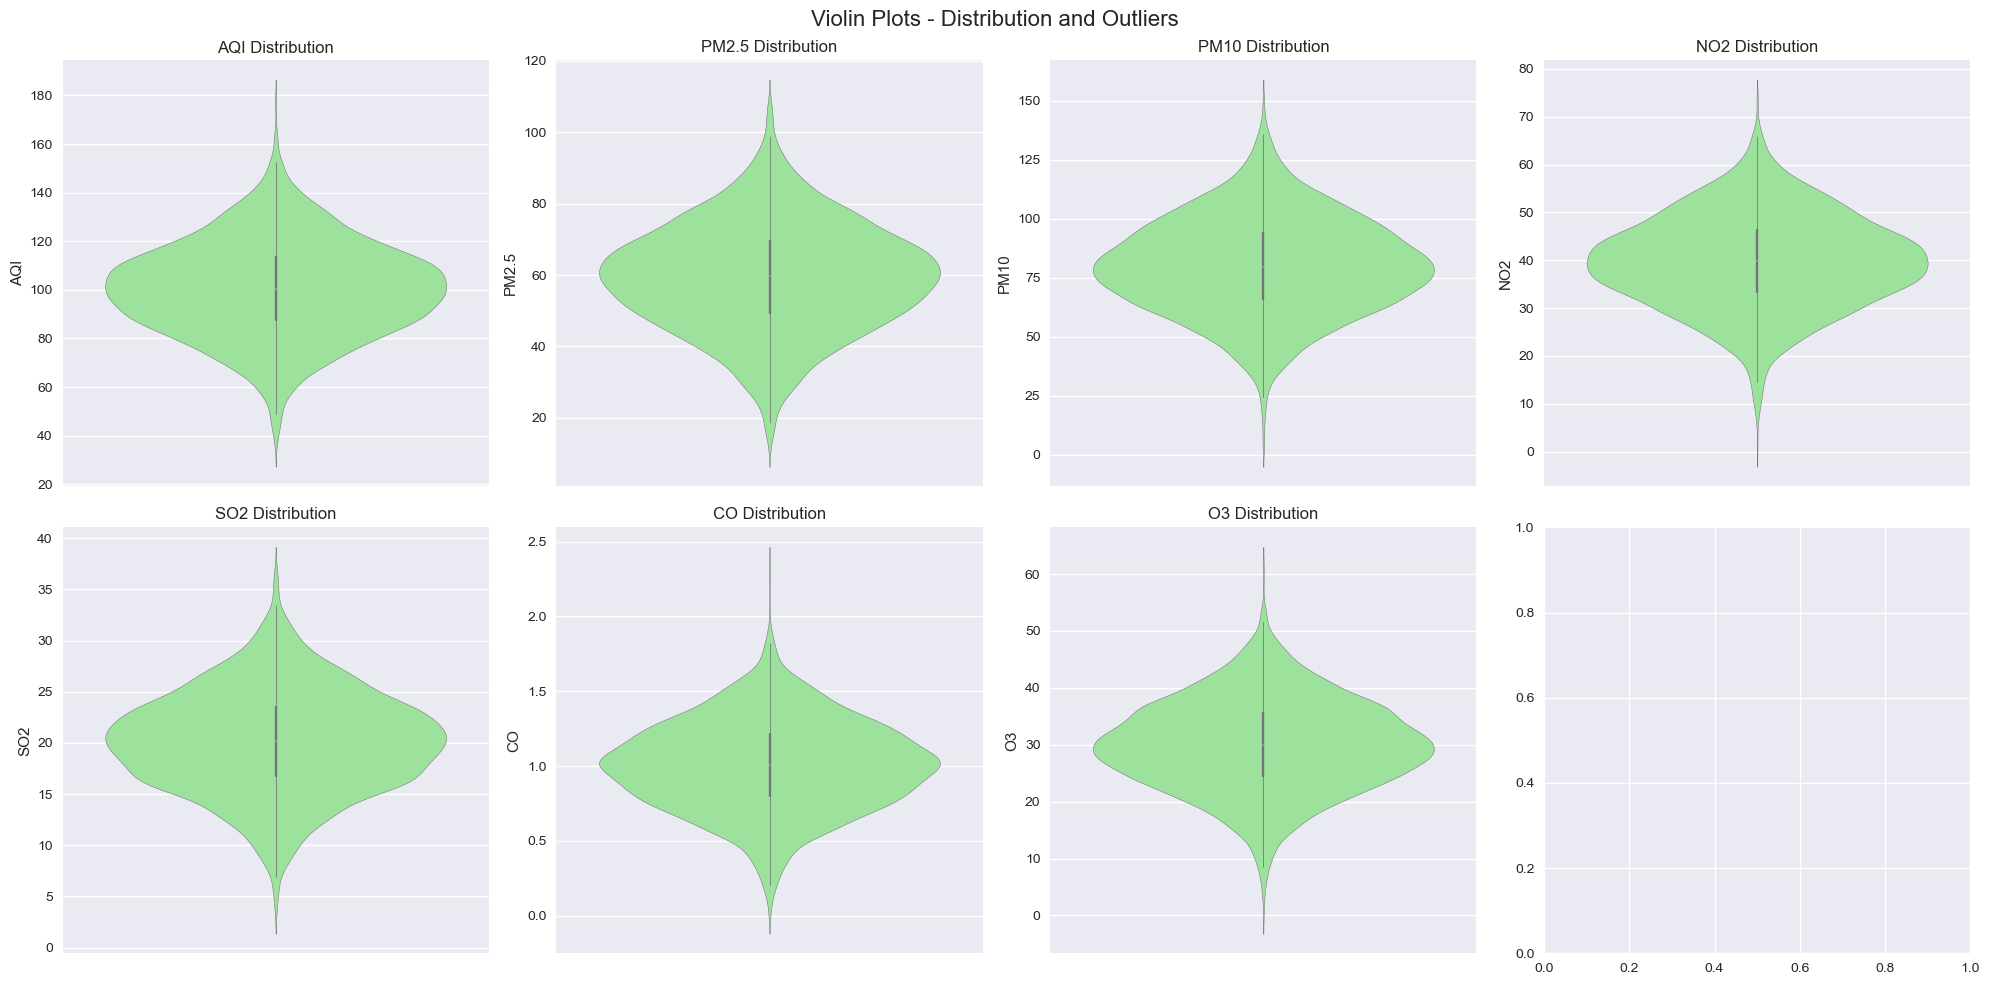


=== DETAILED OUTLIER SUMMARY ===
                        count  percentage  lower_bound  upper_bound
AQI                      29.0        0.97        48.42       152.51
PM2.5                    26.0        0.87        18.91        99.98
PM10                     19.0        0.63        23.97       136.12
NO2                      28.0        0.93        13.70        65.91
SO2                      23.0        0.77         6.62        33.67
CO                       19.0        0.63         0.18         1.83
O3                       23.0        0.77         8.15        51.99
temperature              13.0        0.43        11.25        38.55
humidity                  0.0        0.00       -16.44       125.79
wind_speed                0.0        0.00        -7.36        22.15
precipitation             0.0        0.00        -4.88        14.90
hospital_visits          13.0        0.43         8.00        32.00
emergency_visits         50.0        1.67        -1.50        10.50
mobility_index

In [74]:
# =============================================================================
# 3. OUTLIER DETECTION AND HANDLING
# =============================================================================

def detect_outliers_iqr(df, column):
    """Detect outliers using Interquartile Range method"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

def plot_outliers_visualization(df, columns, outlier_summary):
    """Create comprehensive visualization for outliers"""
    
    # 1. Individual box plots for each column
    n_cols = len(columns)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle('Box Plots for Outlier Detection', fontsize=16)
    
    for i, col in enumerate(columns[:7]):  # Limit to 7 for 2x4 grid
        row = i // 4
        col_idx = i % 4
        
        if i < len(columns):
            # Box plot
            sns.boxplot(y=df[col], ax=axes[row, col_idx], color='lightblue')
            axes[row, col_idx].set_title(f'{col}\n{outlier_summary[col]["count"]} outliers')
            axes[row, col_idx].set_ylabel(col)
            
            # Add outlier count as text
            outlier_count = outlier_summary[col]["count"]
            outlier_pct = outlier_summary[col]["percentage"]
            axes[row, col_idx].text(0.5, 0.95, f'{outlier_count} ({outlier_pct:.1f}%)', 
                                  transform=axes[row, col_idx].transAxes, 
                                  ha='center', va='top', fontsize=10, 
                                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Remove empty subplot
    if n_cols <= 7:
        axes[1, 3].remove()
    
    plt.tight_layout()
    plt.show()
    
    # 2. Outlier summary visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar plot of outlier counts
    outlier_counts = [outlier_summary[col]["count"] for col in columns]
    ax1.bar(columns, outlier_counts, color='coral')
    ax1.set_title('Number of Outliers by Column')
    ax1.set_ylabel('Number of Outliers')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, v in enumerate(outlier_counts):
        ax1.text(i, v + 0.5, str(v), ha='center', va='bottom')
    
    # Bar plot of outlier percentages
    outlier_percentages = [outlier_summary[col]["percentage"] for col in columns]
    ax2.bar(columns, outlier_percentages, color='lightcoral')
    ax2.set_title('Percentage of Outliers by Column')
    ax2.set_ylabel('Percentage (%)')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add percentage labels on bars
    for i, v in enumerate(outlier_percentages):
        ax2.text(i, v + 0.1, f'{v:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Identify numerical columns (excluding date-related columns)
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['year', 'month', 'day', 'day_of_week', 'quarter']
numerical_cols = [col for col in numerical_cols if col not in exclude_cols]

print("\n=== OUTLIER DETECTION ===")
outlier_summary = {}

for col in numerical_cols:
    outliers, lower, upper = detect_outliers_iqr(data, col)
    outlier_summary[col] = {
        'count': len(outliers),
        'percentage': (len(outliers) / len(data)) * 100,
        'lower_bound': lower,
        'upper_bound': upper
    }
    if len(outliers) > 0:
        print(f"{col}: {len(outliers)} outliers ({(len(outliers)/len(data)*100):.2f}%)")

# Create comprehensive outlier visualizations
plot_outliers_visualization(data, numerical_cols, outlier_summary)

# Optional: Create violin plots for better distribution visualization
def plot_violin_outliers(df, columns):
    """Create violin plots to show distribution and outliers"""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle('Violin Plots - Distribution and Outliers', fontsize=16)
    
    for i, col in enumerate(columns[:7]):
        row = i // 4
        col_idx = i % 4
        
        if i < len(columns):
            sns.violinplot(y=df[col], ax=axes[row, col_idx], color='lightgreen')
            axes[row, col_idx].set_title(f'{col} Distribution')
            axes[row, col_idx].set_ylabel(col)
    
    if len(columns) <= 7:
        axes[1, 3].remove()
    
    plt.tight_layout()
    plt.show()

# Create violin plots for additional insight
plot_violin_outliers(data, numerical_cols)

# Print detailed outlier summary
print("\n=== DETAILED OUTLIER SUMMARY ===")
outlier_df = pd.DataFrame(outlier_summary).T
outlier_df = outlier_df.round(2)
print(outlier_df)


## 4. EXPLORATORY DATA ANALYSIS (EDA)


=== STARTING EDA ===


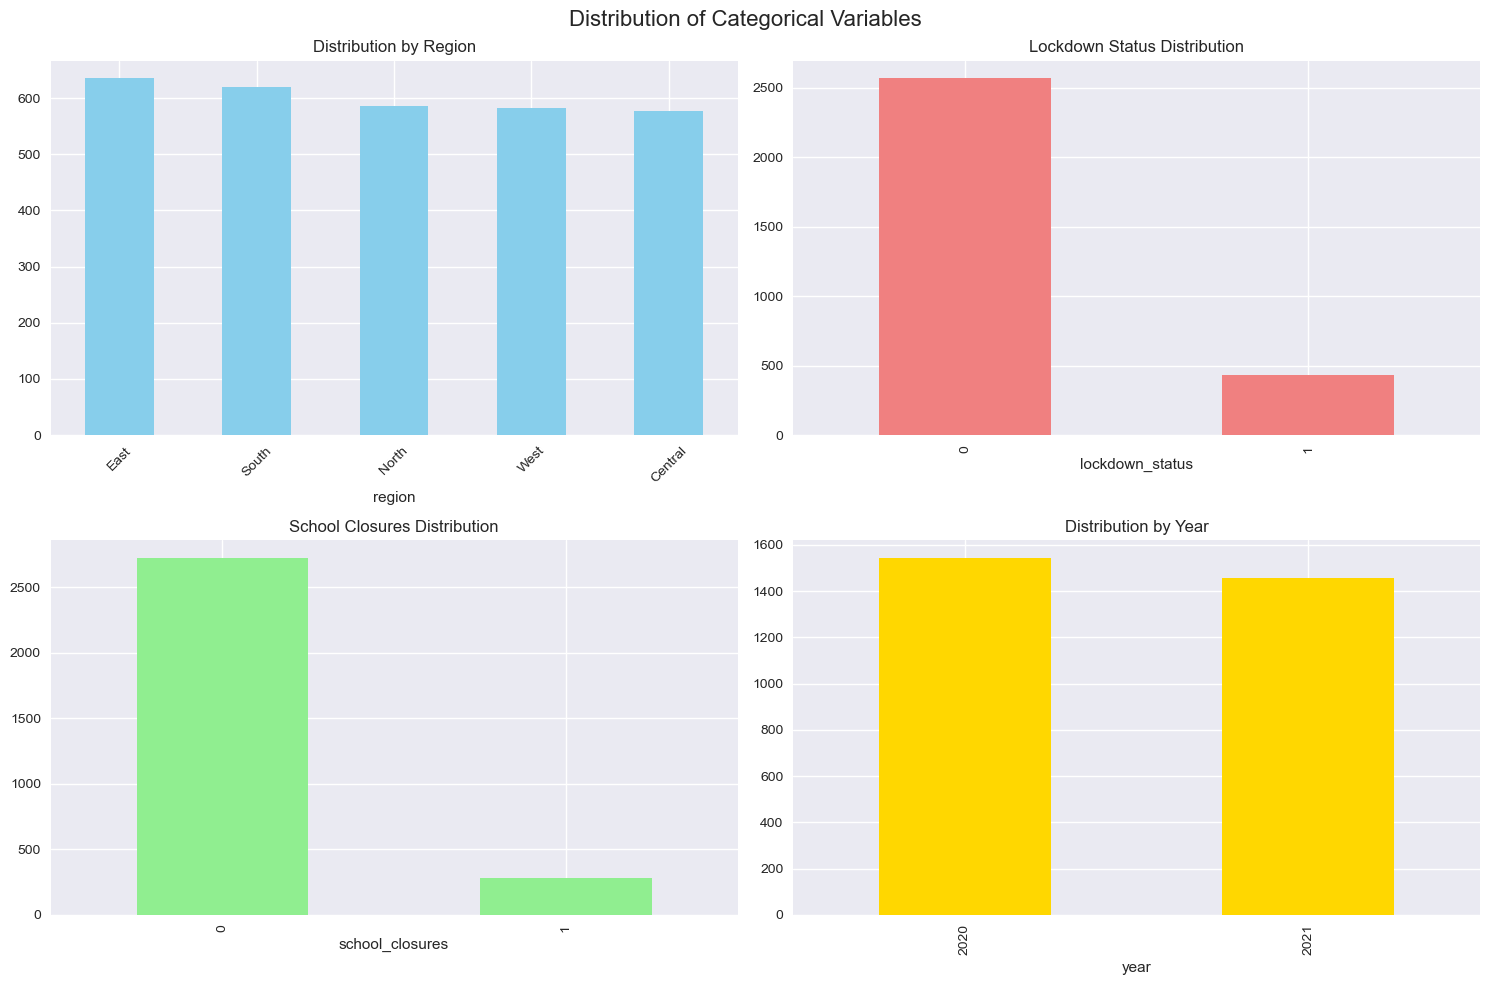

In [75]:
print("\n=== STARTING EDA ===")

# 4.1 Distribution of categorical variables
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution of Categorical Variables', fontsize=16)

# Region distribution
data['region'].value_counts().plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Distribution by Region')
axes[0,0].tick_params(axis='x', rotation=45)

# Lockdown status
data['lockdown_status'].value_counts().plot(kind='bar', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('Lockdown Status Distribution')

# School closures
data['school_closures'].value_counts().plot(kind='bar', ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('School Closures Distribution')

# Year distribution
data['year'].value_counts().plot(kind='bar', ax=axes[1,1], color='gold')
axes[1,1].set_title('Distribution by Year')

plt.tight_layout()
plt.show()

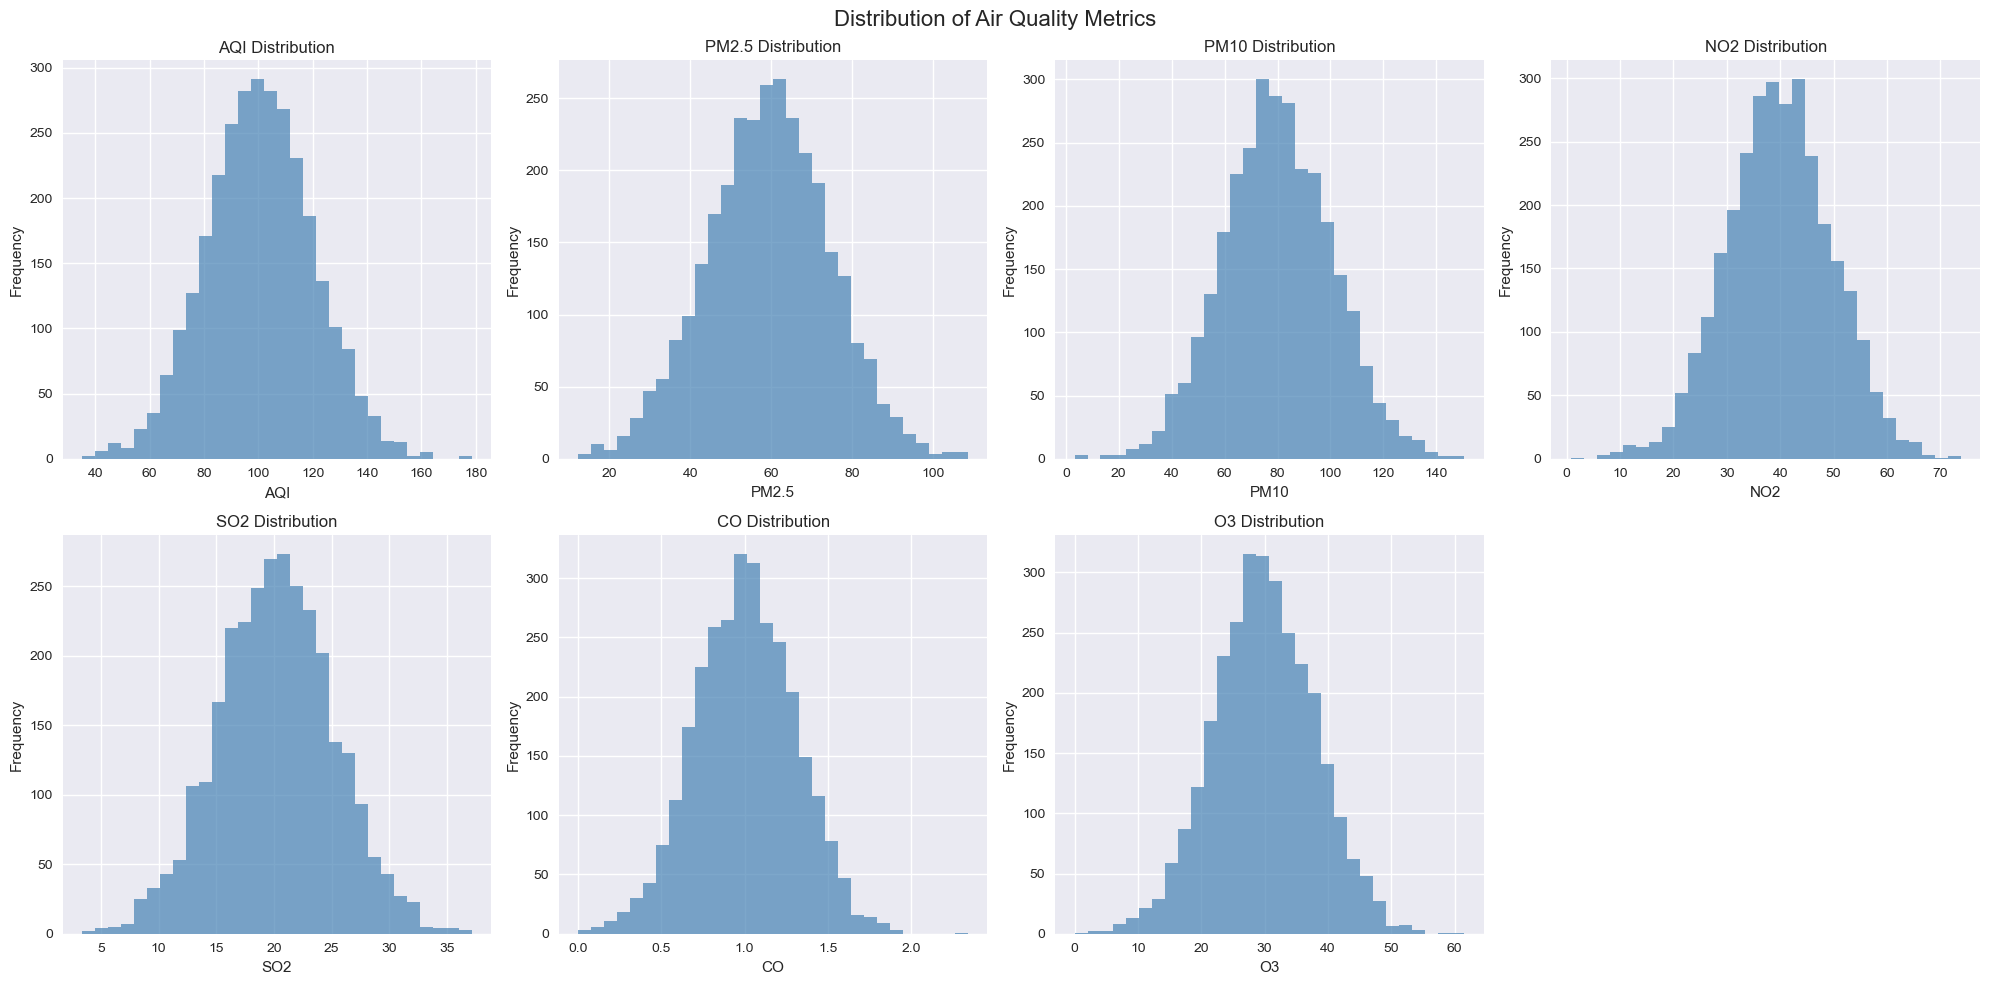

In [76]:
# 4.2 Air Quality Metrics Distribution
air_quality_cols = ['AQI', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Distribution of Air Quality Metrics', fontsize=16)

for i, col in enumerate(air_quality_cols):
    row = i // 4
    col_idx = i % 4
    data[col].hist(bins=30, ax=axes[row, col_idx], alpha=0.7, color='steelblue')
    axes[row, col_idx].set_title(f'{col} Distribution')
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('Frequency')

# Remove empty subplot
axes[1, 3].remove()
plt.tight_layout()
plt.show()

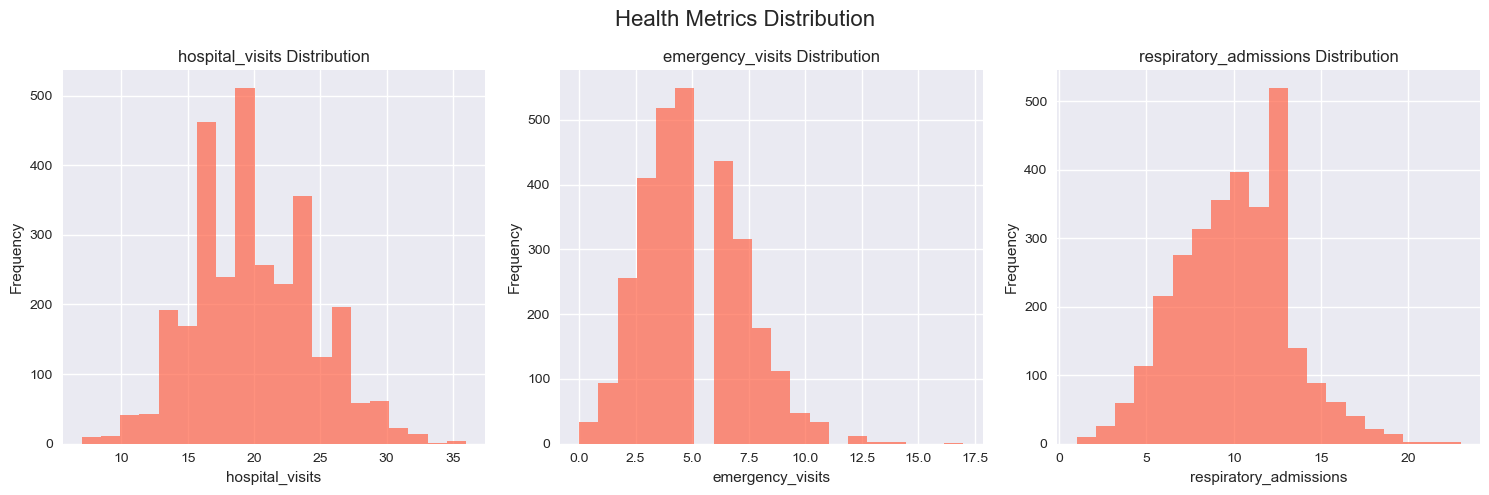

In [77]:
# 4.3 Health Metrics Analysis
health_cols = ['hospital_visits', 'emergency_visits', 'respiratory_admissions']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Health Metrics Distribution', fontsize=16)

for i, col in enumerate(health_cols):
    data[col].hist(bins=20, ax=axes[i], alpha=0.7, color='tomato')
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


=== CORRELATION ANALYSIS ===


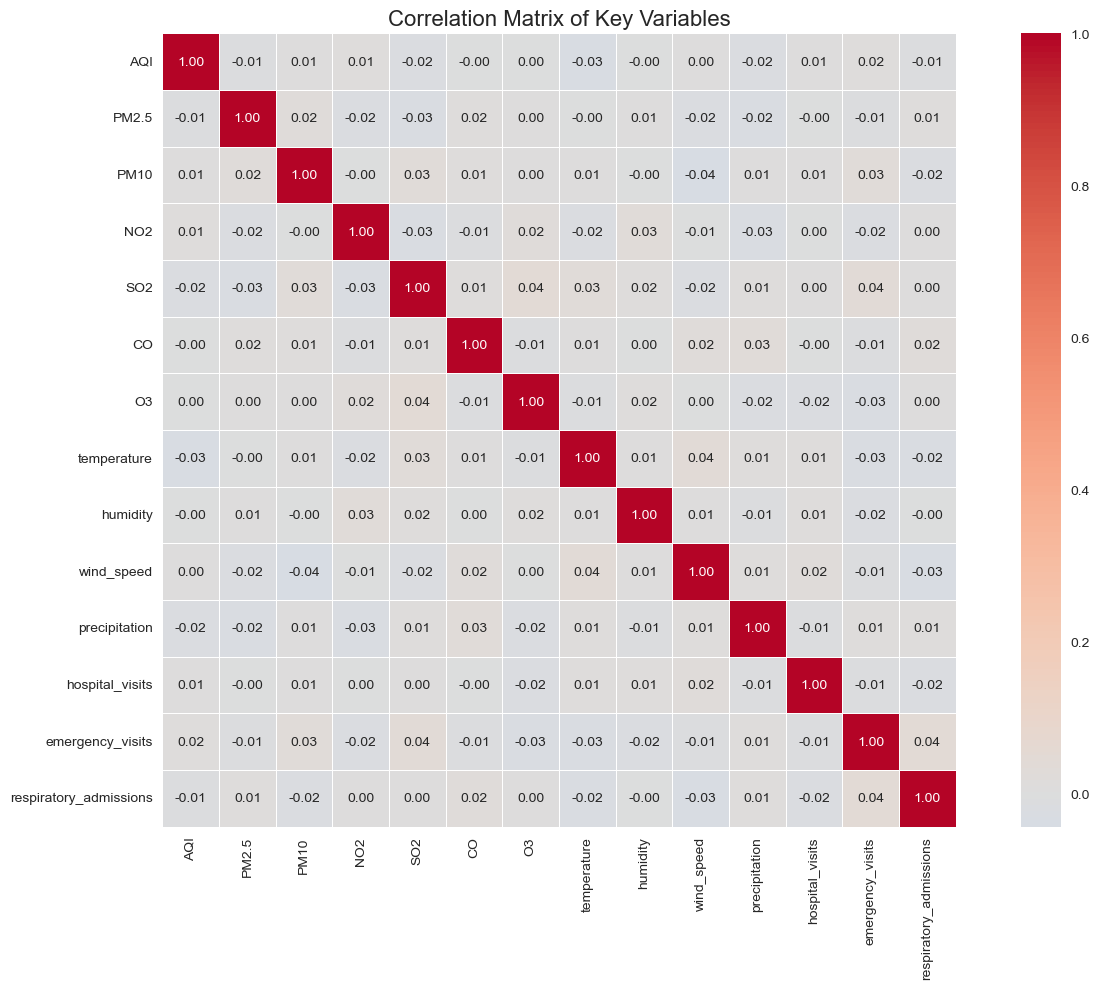

In [78]:
# 4.4 Correlation Analysis
print("\n=== CORRELATION ANALYSIS ===")

# Select numerical columns for correlation
corr_cols = ['AQI', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 
             'temperature', 'humidity', 'wind_speed', 'precipitation',
             'hospital_visits', 'emergency_visits', 'respiratory_admissions']

correlation_matrix = data[corr_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix of Key Variables', fontsize=16)
plt.tight_layout()
plt.show()

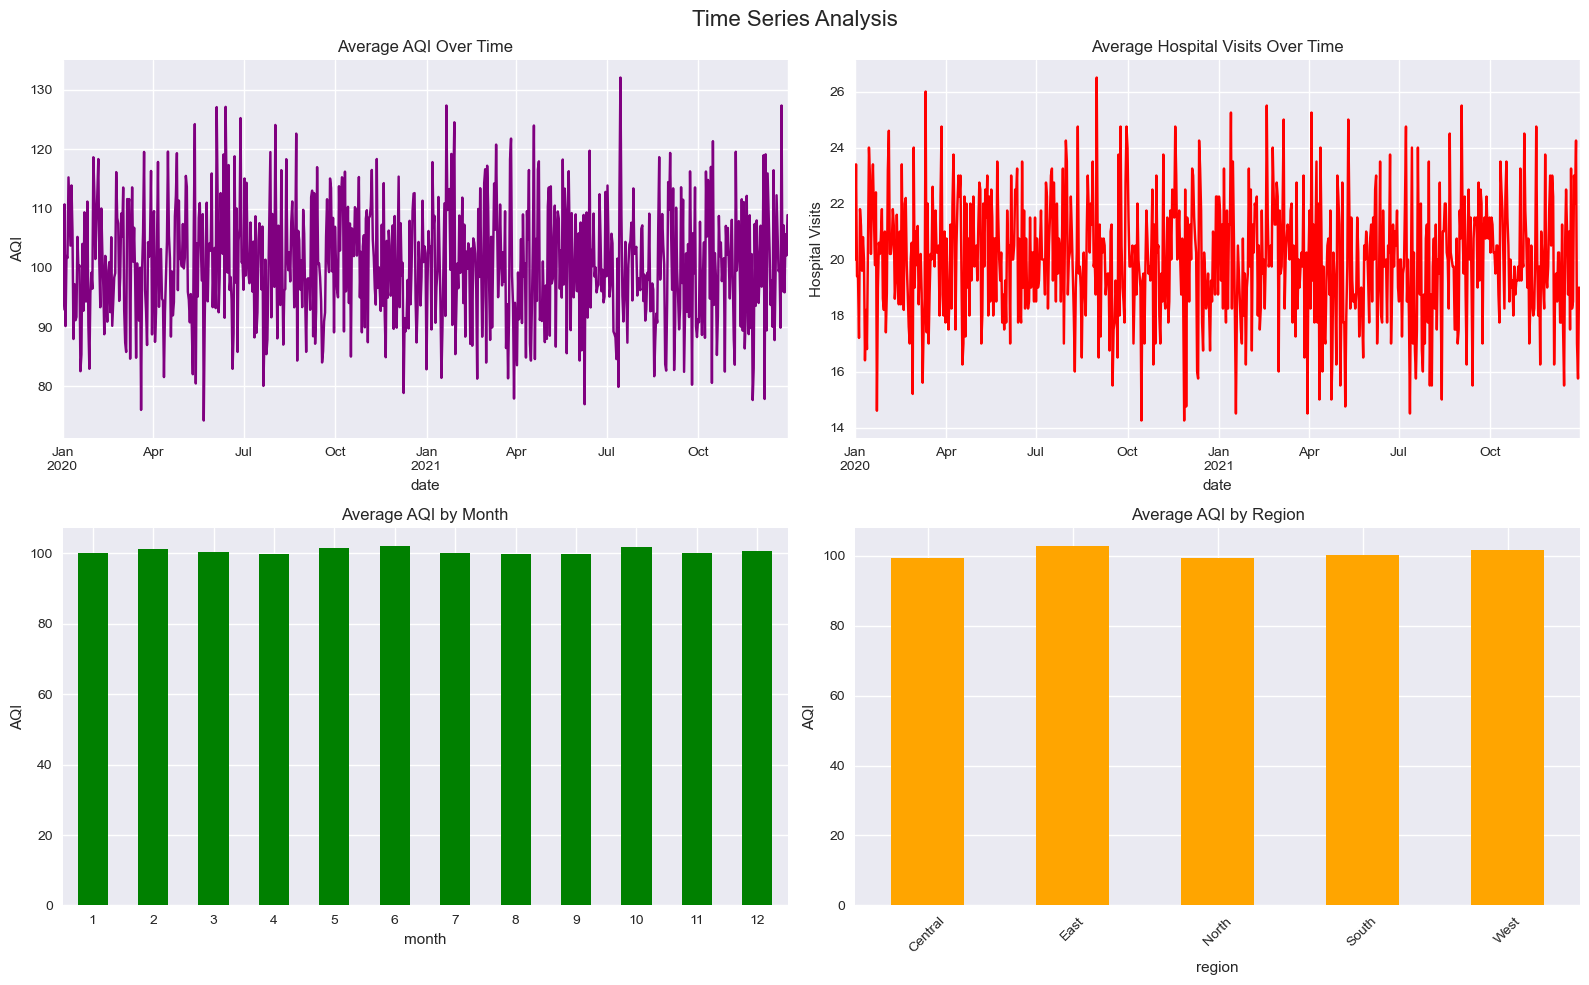

In [79]:
# 4.5 Time Series Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Time Series Analysis', fontsize=16)

# AQI over time
data.groupby('date')['AQI'].mean().plot(ax=axes[0,0], color='purple')
axes[0,0].set_title('Average AQI Over Time')
axes[0,0].set_ylabel('AQI')

# Hospital visits over time
data.groupby('date')['hospital_visits'].mean().plot(ax=axes[0,1], color='red')
axes[0,1].set_title('Average Hospital Visits Over Time')
axes[0,1].set_ylabel('Hospital Visits')

# Monthly patterns
monthly_aqi = data.groupby('month')['AQI'].mean()
monthly_aqi.plot(kind='bar', ax=axes[1,0], color='green')
axes[1,0].set_title('Average AQI by Month')
axes[1,0].set_ylabel('AQI')
axes[1,0].tick_params(axis='x', rotation=0)

# Regional comparison
regional_aqi = data.groupby('region')['AQI'].mean()
regional_aqi.plot(kind='bar', ax=axes[1,1], color='orange')
axes[1,1].set_title('Average AQI by Region')
axes[1,1].set_ylabel('AQI')
axes[1,1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


## 5. DATA ENCODING

In [80]:
print("\n=== DATA ENCODING ===")

# Create a copy for preprocessing
data_processed = data.copy()

# Label encode categorical variables
label_encoders = {}
categorical_cols = ['region']

for col in categorical_cols:
    le = LabelEncoder()
    data_processed[col + '_encoded'] = le.fit_transform(data_processed[col])
    label_encoders[col] = le
    print(f"✓ {col} encoded: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# One-hot encode if needed (alternative approach)
# region_dummies = pd.get_dummies(data['region'], prefix='region')
# data_processed = pd.concat([data_processed, region_dummies], axis=1)


=== DATA ENCODING ===
✓ region encoded: {'Central': np.int64(0), 'East': np.int64(1), 'North': np.int64(2), 'South': np.int64(3), 'West': np.int64(4)}


## 6. FEATURE SCALING

In [81]:
print("\n=== FEATURE SCALING ===")

# Select features for scaling (exclude date parts and AQI itself)
features_to_scale = [
    col for col in numerical_cols 
    if col not in ['year', 'month', 'day', 'day_of_week', 'quarter', 'AQI']
]

# Initialize scaler
scaler = StandardScaler()

# Fit and transform the selected features
data_processed[features_to_scale] = scaler.fit_transform(data_processed[features_to_scale])

print(f"✓ Scaled {len(features_to_scale)} numerical features (excluding AQI)")



=== FEATURE SCALING ===
✓ Scaled 23 numerical features (excluding AQI)


In [82]:
# 6.1 TIME-SERIES FEATURE ENGINEERING
print("\n=== ADDING LAG & ROLLING FEATURES ===")

# Make sure data is sorted by date
data_processed = data_processed.sort_values("date")

# Define how many days to look back
lags = [1, 3, 7]   # yesterday, 3 days ago, 7 days ago
rolling_windows = [7, 14]  # 7-day avg, 14-day avg

for lag in lags:
    data_processed[f"AQI_lag{lag}"] = data_processed['AQI'].shift(lag)

for window in rolling_windows:
    data_processed[f"AQI_roll{window}"] = data_processed['AQI'].shift(1).rolling(window).mean()

# Drop rows with NaN (caused by lag/rolling at start of series)
data_processed = data_processed.dropna().reset_index(drop=True)

print(f"✓ Added {len(lags)} lag features and {len(rolling_windows)} rolling average features")



=== ADDING LAG & ROLLING FEATURES ===
✓ Added 3 lag features and 2 rolling average features



## 7. TRAIN-VALIDATION-TEST SPLIT

In [83]:
# 7. TIME-AWARE DATA SPLITTING
print("\n=== TIME-AWARE DATA SPLITTING ===")

# Sort by date to ensure temporal order
data_processed = data_processed.sort_values("date").reset_index(drop=True)

# Define features and target
target_column = "AQI"
exclude_features = ["date", "region", target_column]
feature_columns = [col for col in data_processed.columns if col not in exclude_features]

X = data_processed[feature_columns]
y = data_processed[target_column]

# Split by time order: 70% train, 15% validation, 15% test
n = len(data_processed)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")



=== TIME-AWARE DATA SPLITTING ===
Training set: 2090 samples
Validation set: 448 samples
Test set: 448 samples


In [84]:
print("\n=== FEATURE ENGINEERING ===")

# Copy of processed dataset
data_fe = data_processed.copy()

# Rolling averages (for AQI trends)
data_fe['AQI_rolling_7'] = data_fe['AQI'].rolling(window=7, min_periods=1).mean()
data_fe['AQI_rolling_30'] = data_fe['AQI'].rolling(window=30, min_periods=1).mean()

# Lag features (previous day's AQI and pollutants)
for lag in [1, 3, 7]:
    data_fe[f"AQI_lag_{lag}"] = data_fe['AQI'].shift(lag)
    data_fe[f"PM25_lag_{lag}"] = data_fe['PM2.5'].shift(lag)
    data_fe[f"PM10_lag_{lag}"] = data_fe['PM10'].shift(lag)

# Interaction terms (pollutants × weather)
data_fe['PM25_humidity'] = data_fe['PM2.5'] * data_fe['humidity']
data_fe['PM10_temperature'] = data_fe['PM10'] * data_fe['temperature']
data_fe['NO2_wind'] = data_fe['NO2'] * data_fe['wind_speed']

# Fill NaN created by lag features
data_fe.fillna(method="bfill", inplace=True)

print(f"✓ Feature engineering added: {data_fe.shape[1]} total features")

# Redefine features and target
exclude_features = ['date', 'region', 'AQI']
feature_columns = [col for col in data_fe.columns if col not in exclude_features]
X = data_fe[feature_columns]
y = data_fe['AQI']

# Redo train-val-test split
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("✓ New train/val/test split completed with engineered features")



=== FEATURE ENGINEERING ===
✓ Feature engineering added: 51 total features
✓ New train/val/test split completed with engineered features


In [85]:
# 9.1 BASELINE MODEL TRAINING
print("\n=== BASELINE MODEL TRAINING ===")

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Helper function to evaluate models with accuracy %
def evaluate_model(name, model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    mean_target = np.mean(y_val)
    accuracy = 100 * (1 - rmse / mean_target) if mean_target != 0 else 0
    
    print(f"\n{name} Performance:")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE:  {mae:.3f}")
    print(f"R²:   {r2:.3f}")
    print(f"Accuracy: {accuracy:.2f}%")
    
    return model


# Linear Regression
lr_model = evaluate_model("Linear Regression", LinearRegression(), 
                          X_train, y_train, X_val, y_val)

# Random Forest
rf_model = evaluate_model("Random Forest", 
                          RandomForestRegressor(n_estimators=100, random_state=42), 
                          X_train, y_train, X_val, y_val)

# 9.2 ADVANCED MODEL - XGBoost
print("\n=== XGBOOST MODEL TRAINING ===")

from xgboost import XGBRegressor

xgb_model = evaluate_model("XGBoost", 
                           XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42),
                           X_train, y_train, X_val, y_val)



=== BASELINE MODEL TRAINING ===

Linear Regression Performance:
RMSE: 15.771
MAE:  12.707
R²:   0.367
Accuracy: 84.37%

Random Forest Performance:
RMSE: 16.739
MAE:  13.352
R²:   0.287
Accuracy: 83.41%

=== XGBOOST MODEL TRAINING ===

XGBoost Performance:
RMSE: 16.383
MAE:  12.982
R²:   0.317
Accuracy: 83.76%



=== FEATURE IMPORTANCE ===


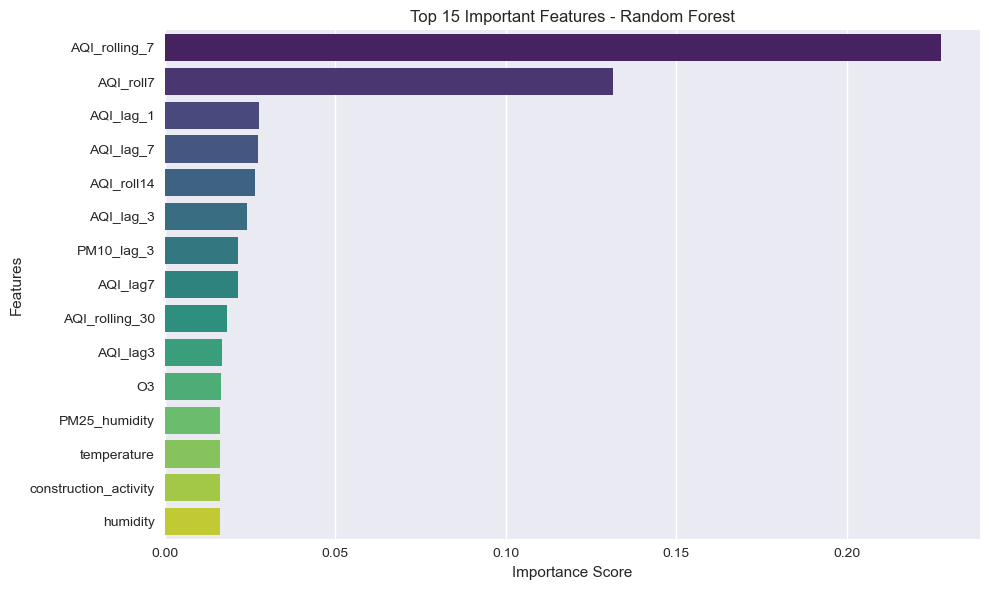

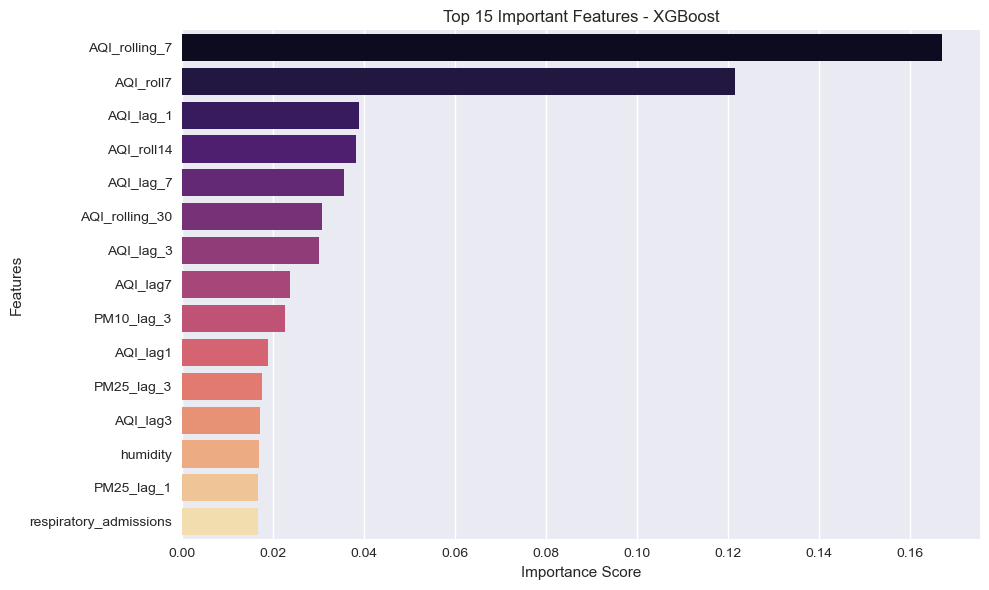

In [86]:
# 9.3 FEATURE IMPORTANCE
print("\n=== FEATURE IMPORTANCE ===")

import matplotlib.pyplot as plt
import seaborn as sns

# Random Forest feature importance
rf_importances = rf_model.feature_importances_
rf_features = pd.Series(rf_importances, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=rf_features[:15], y=rf_features.index[:15], palette="viridis")
plt.title("Top 15 Important Features - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# XGBoost feature importance
xgb_importances = xgb_model.feature_importances_
xgb_features = pd.Series(xgb_importances, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_features[:15], y=xgb_features.index[:15], palette="magma")
plt.title("Top 15 Important Features - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()



## 8. SAVE PROCESSED DATA

In [87]:
print("\n=== SAVING PROCESSED DATA ===")

# Save the processed dataset
data_processed.to_csv('air_quality_processed.csv', index=False)

# Save splits separately if needed
X_train.to_csv('X_train.csv', index=False)
X_val.to_csv('X_val.csv', index=False)
X_test.to_csv('X_test.csv', index=False)

pd.DataFrame(y_train).to_csv('y_train.csv', index=False)
pd.DataFrame(y_val).to_csv('y_val.csv', index=False)
pd.DataFrame(y_test).to_csv('y_test.csv', index=False)

print("✓ All processed data saved successfully!")


=== SAVING PROCESSED DATA ===
✓ All processed data saved successfully!


## 10. SUMMARY STATISTICS

In [88]:
print("\n=== FINAL SUMMARY ===")
print(f"Original dataset shape: {data.shape}")
print(f"Processed dataset shape: {data_processed.shape}")
print(f"Number of features after preprocessing: {X.shape[1]}")
print(f"Target variable: {target_column}")
print(f"Total missing values after cleaning: {data_processed.isnull().sum().sum()}")



# Display feature importance (correlation with target)
feature_importance = abs(data_processed[feature_columns + [target_column]].corr()[target_column]).sort_values(ascending=False)[1:]
print(f"\nTop 10 features by correlation with {target_column}:")
print(feature_importance.head(10))

print("\n🎉 Data preprocessing completed successfully!")


=== FINAL SUMMARY ===
Original dataset shape: (3000, 31)
Processed dataset shape: (2986, 37)
Number of features after preprocessing: 48
Target variable: AQI
Total missing values after cleaning: 0


KeyError: "['AQI_rolling_7', 'AQI_rolling_30', 'AQI_lag_1', 'PM25_lag_1', 'PM10_lag_1', 'AQI_lag_3', 'PM25_lag_3', 'PM10_lag_3', 'AQI_lag_7', 'PM25_lag_7', 'PM10_lag_7', 'PM25_humidity', 'PM10_temperature', 'NO2_wind'] not in index"